In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

In [2]:
DATA_DIR = "data"

## Data

In [3]:
headlines_df = pd.read_csv(os.path.join(DATA_DIR, "headlines-with-latlon.csv"))
headlines_df.head()

,headline,city,countrycode,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667


In [4]:
latitudes = headlines_df["latitude"].values
longitudes = headlines_df["longitude"].values
coordinates = np.vstack((latitudes, longitudes)).T

latitudes.shape, longitudes.shape, coordinates.shape

((600,), (600,), (600, 2))

## Baseline plots

In [5]:
map_plotter = Basemap()

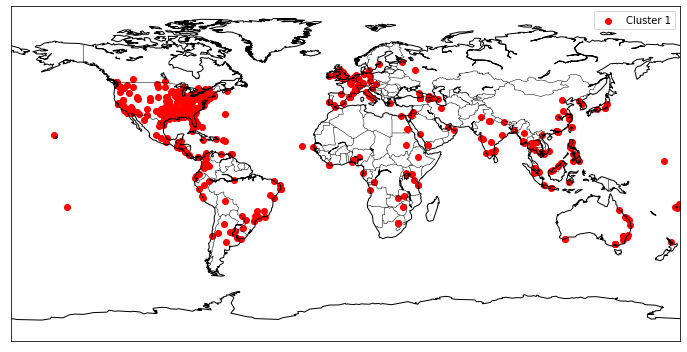

In [6]:
def scatterplot_world(map_plotter, coordinates_list, colors):
    assert(len(coordinates_list) == len(colors))
    fig = plt.figure(figsize=(12, 8))
    for cid, (coordinates, color) in enumerate(zip(coordinates_list, colors)):
        latitudes, longitudes = coordinates[:, 0], coordinates[:, 1]
        map_plotter.scatter(longitudes, latitudes, latlon=True, color=color, 
                            label="Cluster {:d}".format(cid + 1))
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    plt.legend(loc="best")
    _ = plt.show()
    
scatterplot_world(map_plotter, [coordinates], ["r"])

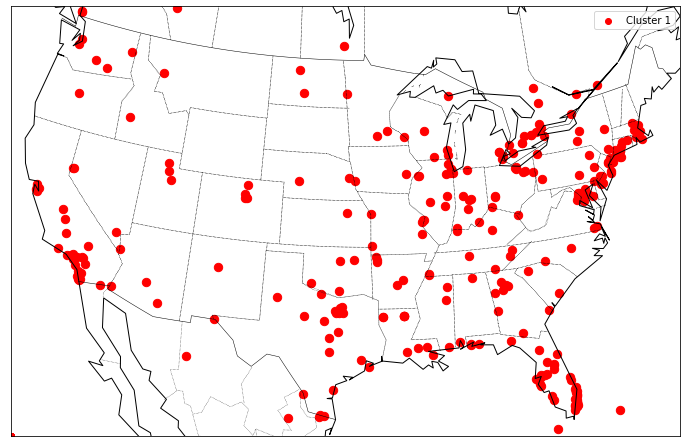

In [7]:
def scatterplot_us(map_plotter, coordinates_list, colors):
    assert(len(coordinates_list) == len(colors))
    fig = plt.figure(figsize=(12, 8))
    map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119,
                      llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, 
                      lat_1=33,lat_2=45)
    for cid, (coordinates, color) in enumerate(zip(coordinates_list, colors)):
        latitudes, longitudes = coordinates[:, 0], coordinates[:, 1]
        map_plotter.scatter(longitudes, latitudes, latlon=True, color=color,
                            label="Cluster {:d}".format(cid + 1))
    map_lcc.scatter(longitudes, latitudes, latlon=True, s=70, color='r')
    map_lcc.drawcoastlines()
    map_lcc.drawcountries()
    map_lcc.drawstates(linestyle="dotted")
    plt.legend(loc="best")
    _ = plt.show()
    
scatterplot_us(map_plotter, [coordinates], ["r"])

## KMeans Clustering

### Determine K using Elbow method

Optimum choice of k seems to be 3 from the plot below.

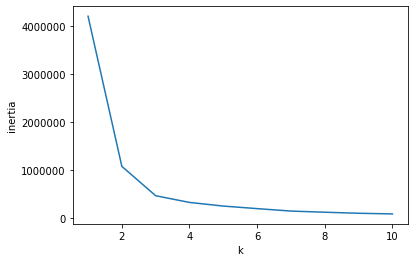

In [8]:
k_choices = np.arange(1, 11)
inertia_values = [KMeans(k).fit(coordinates).inertia_ for k in k_choices]

plt.plot(k_choices, inertia_values)
plt.xlabel("k")
plt.ylabel("inertia")
_ = plt.show()

In [9]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(coordinates)

coordinates_pred = headlines_df[["latitude", "longitude"]].values
headlines_df["cluster"] = model.predict(coordinates_pred)

headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,0
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


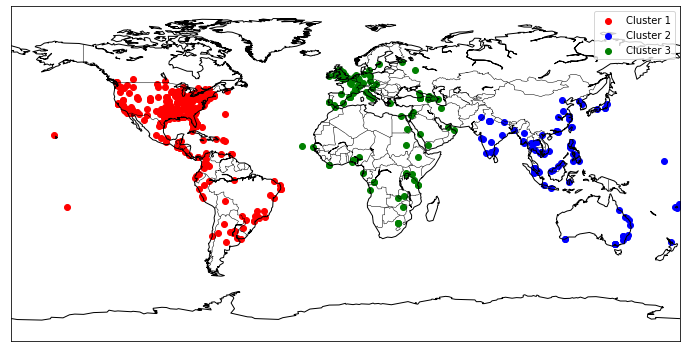

In [10]:
coordinates_list = [
    headlines_df[headlines_df["cluster"]==0][["latitude", "longitude"]].values,
    headlines_df[headlines_df["cluster"]==1][["latitude", "longitude"]].values,
    headlines_df[headlines_df["cluster"]==2][["latitude", "longitude"]].values
]
colors = ["r", "b", "g"]
scatterplot_world(map_plotter, coordinates_list, colors)

In [ ]:
headlines_df.to_csv(os.path.join(DATA_DIR, "headlines-clustered-kmeans.csv"), index=False)

## DBSCAN

### Determine best eps

From the supplied documentation:

>Generally speaking, if we are clustering random cities spread out across the Earth, then we can set the min_samples and eps parameters to equal 3 cities and 250 miles, respectively. This will assume each cluster holds a city that is within 250 miles of at-least 3 other clustered cities. For a more regional location distribution, a lower eps value will be required.

Distance measure being used currently is `euclidean` so these hyperparameters will probably not hold. Once we start using the Great Circle distance, we can use these hyperparameters with more confidence.

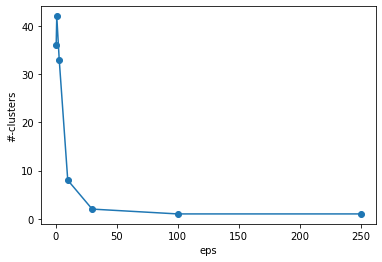

In [11]:
eps_choices = [0.5, 1, 3, 10, 30, 100, 250]
num_clusters = [len(np.unique(
    DBSCAN(min_samples=3, eps=eps).fit_predict(coordinates))) for eps in eps_choices]

plt.plot(eps_choices, num_clusters, marker='o')
plt.xlabel("eps")
plt.ylabel("#-clusters")
_ = plt.show()

In [12]:
num_clusters

[36, 42, 33, 8, 2, 1, 1]

### DBSCAN (eps=10, num_clusters=8)

In [13]:
model_1 = DBSCAN(min_samples=3, eps=10)
clusters = model_1.fit_predict(coordinates)
headlines_df["cluster"] = clusters
headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,1
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


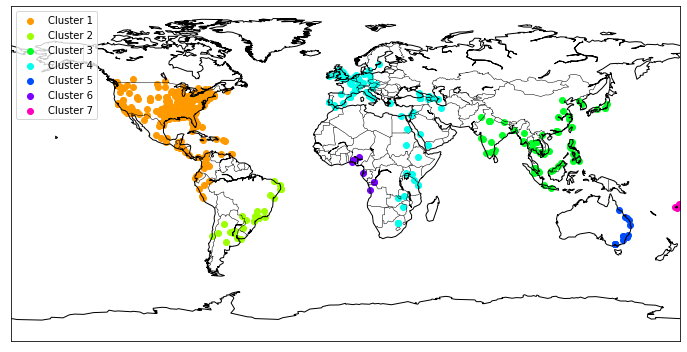

In [14]:
coordinates_list, colors = [], []

cluster_ids = np.unique(headlines_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    if cluster_ids[i] == -1:
        continue
    coordinates_list.append(
        headlines_df[headlines_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_world(map_plotter, coordinates_list, colors)

In [ ]:
headlines_df.to_csv(os.path.join(DATA_DIR, "headlines-clustered-dbscan-euclidean.csv"), index=False)

### DBSCAN (metric: Great Circle Distance)

* [Formula for Great Circle Distance](https://en.wikipedia.org/wiki/Great-circle_distance) on Wikipedia.
* Provided by Scikit-Learn as [Haversine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html) but looks like its new or deprecated, not available in the scikit-learn version provided for this project.

So we have to build this ourselves and call DBSCAN with `metric="precomputed"`.

In [15]:
def great_circle_distances(coordinates, radius=3956):
    D = np.zeros((len(coordinates), len(coordinates)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            if i >= j:
                # only compute lower triangle
                continue
                
            coord_1 = np.radians(coordinates[i])
            coord_2 = np.radians(coordinates[j])
            
            if np.array_equal(coord_1, coord_2):
                D[i, j] = 0
                D[j, i] = 0
                
            delta_x, delta_y = coord_2 - coord_1
            haversin = np.sin(delta_x / 2) ** 2 + (
                np.cos(coord_1[0]) * np.cos(coord_2[0]) * np.sin(delta_y / 2) ** 2)
            D[i, j] = 2 * radius * np.arcsin(haversin ** 0.5)
            D[j, i] = D[i, j]
    return np.nan_to_num(D)

distances = great_circle_distances(coordinates)
distances.shape

(600, 600)

In [16]:
model_2 = DBSCAN(min_samples=3, eps=250, metric="precomputed")
clusters = model_2.fit_predict(distances)

In [17]:
cluster_ids, cluster_counts = np.unique(clusters, return_counts=True)
for cluster_id, cluster_count in zip(cluster_ids, cluster_counts):
    print(cluster_id, cluster_count)

-1 81
0 256
1 4
2 16
3 52
4 12
5 12
6 7
7 6
8 9
9 10
10 4
11 4
12 8
13 3
14 4
15 3
16 3
17 4
18 5
19 3
20 3
21 14
22 33
23 4
24 3
25 3
26 11
27 3
28 4
29 4
30 3
31 3
32 3
33 3


In [18]:
headlines_df["cluster"] = clusters
headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,1
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


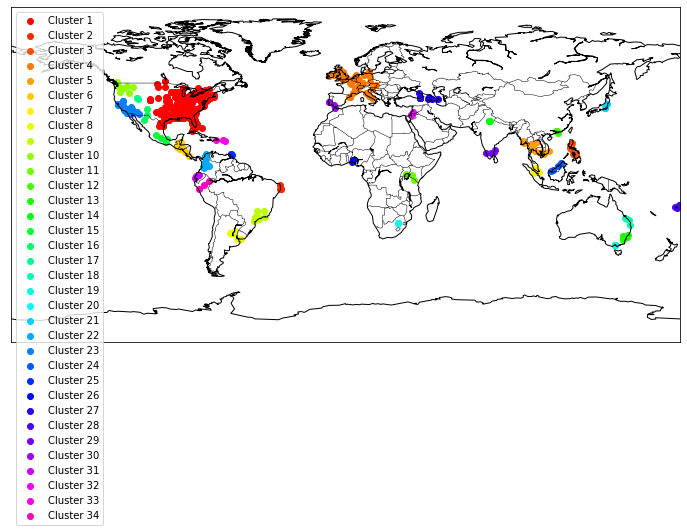

In [19]:
coordinates_list, colors = [], []

cluster_ids = np.unique(headlines_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    if cluster_ids[i] == -1:
        continue
    coordinates_list.append(
        headlines_df[headlines_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_world(map_plotter, coordinates_list, colors)

In [ ]:
headlines_df.to_csv(os.path.join(DATA_DIR, "headlines-clus.csv"), index=False)